# 第十一章 分类任务的表示模型微调

## 监督分类

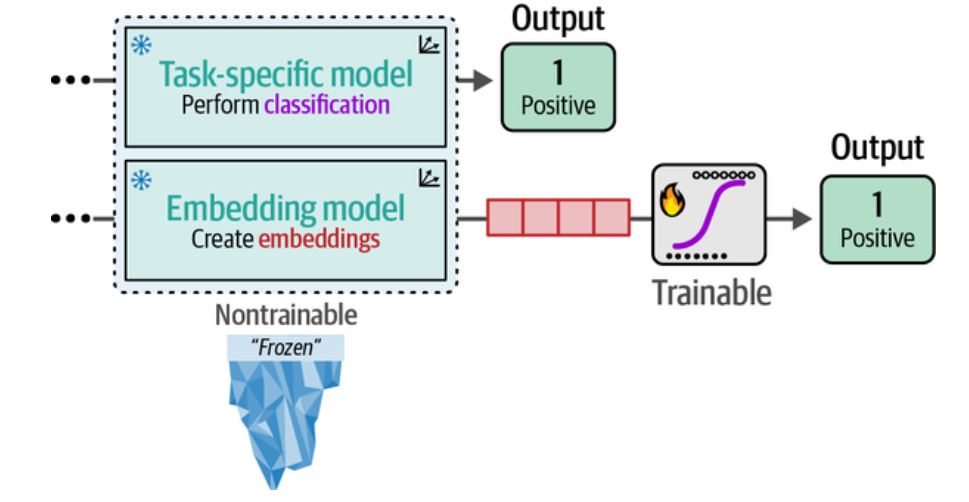

两个模型都保持“冻结”（不可训练）状态，以展示利用预训练模型进行分类任务的潜力。嵌入模型使用了一个独立的可训练分类头（分类器）来预测电影评论的情感。

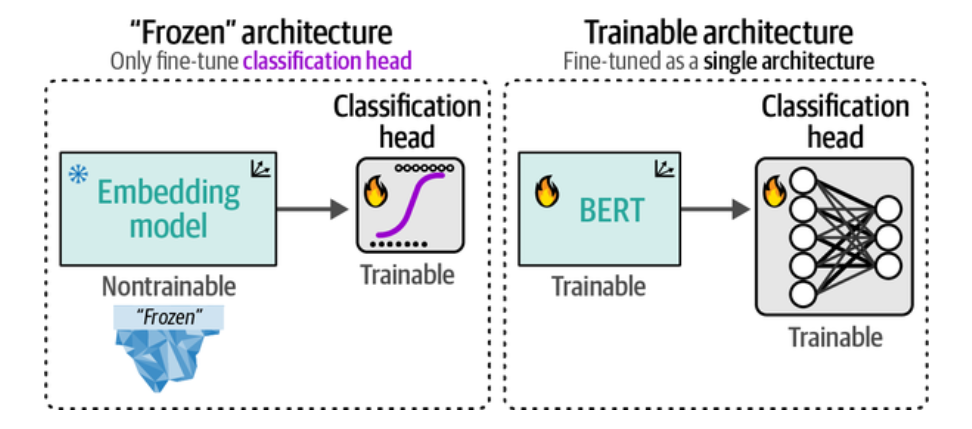

与嵌入模型方法相比，我们将表示模型和分类头作为一个整体架构进行微调。为了做到这一点，我们不再冻结模型，而是允许它在训练过程中可训练并更新其参数。

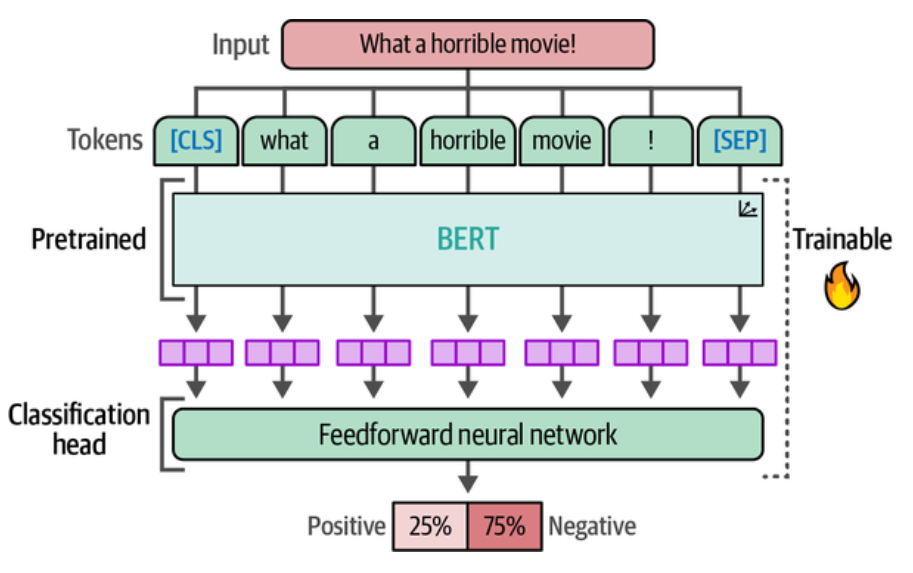

我们将使用一个预训练的BERT模型，并添加一个神经网络作为分类头，这两部分都将针对分类任务进行微调。在实践中，这意味着预训练的BERT模型和分类头是联合更新的。它们不是独立的过程，而是相互学习，从而能够提供更准确的表示。

### 微调预训练的BERT模型

我们将使用与第4章中相同的数据集来微调我们的模型，即Rotten Tomatoes数据集，该数据集包含来自Rotten Tomatoes的5,331条正面和5,331条负面电影评论：

In [ ]:
from datasets import load_dataset

# 准备数据并进行划分
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 加载模型和分词器
# 第一步，选择我们想要使用的底层模型
model_id = "bert-base-cased"
# 事先定义想要预测的标签数量
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# Transformer的模型处理固定长度的输入时表现最佳
from transformers import DataCollatorWithPadding

# 将序列填充至批次中最长序列的长度
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)
# truncation=True确保如果文本长度超过了分词器设置的最大长度限制，则会被截断。

# 对训练/测试数据进行分词
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)
# map方法会以批次的形式处理数据，有助于减少内存使用并提高处理速度。

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# 定义评估指标
import numpy as np
import evaluate

# 在训练过程中记录，有助于检测过拟合行为。
def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

In [ ]:
# 实例化Trainer：
from transformers import TrainingArguments, Trainer

# 参数调优的训练参数
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# 执行训练过程的训练器
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# 训练模型
trainer.train()

TrainOutput(global_step=534, training_loss=0.4183677966228585, metrics={'train_runtime': 61.6658, 'train_samples_per_second': 138.326, 'train_steps_per_second': 8.66, 'total_flos': 227605451772240.0, 'train_loss': 0.4183677966228585, 'epoch': 1.0})

In [ ]:
# 评估模型
trainer.evaluate()

{'eval_loss': 0.37090229988098145,
 'eval_f1': 0.8566073102155576,
 'eval_runtime': 3.1133,
 'eval_samples_per_second': 342.407,
 'eval_steps_per_second': 21.521,
 'epoch': 1.0}

### 冻结层

- 展示训练整个网络的重要性

##### 冻结主要的BERT模型

In [ ]:
# 初始化模型
# 加载模型和分词器
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 检查这些层，了解网络的结构以及可能想要冻结的部分：
# 打印层名
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

该模型由12个（编号为0–11）编码器块组成，每个编码器块都包含注意力头、密集网络层和层归一化。

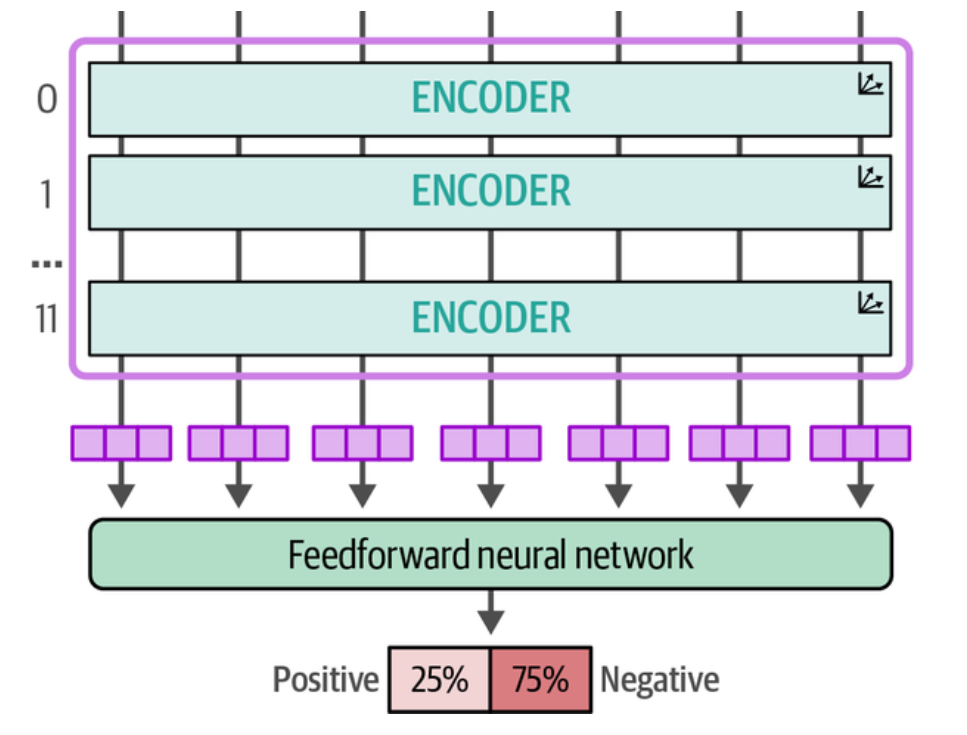

我们可以选择只冻结某些层来加快计算速度，但仍允许主要模型从分类任务中学习。通常，我们希望冻结层后面是可训练的层。

In [ ]:
# 冻结除分类头以外的所有内容：
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

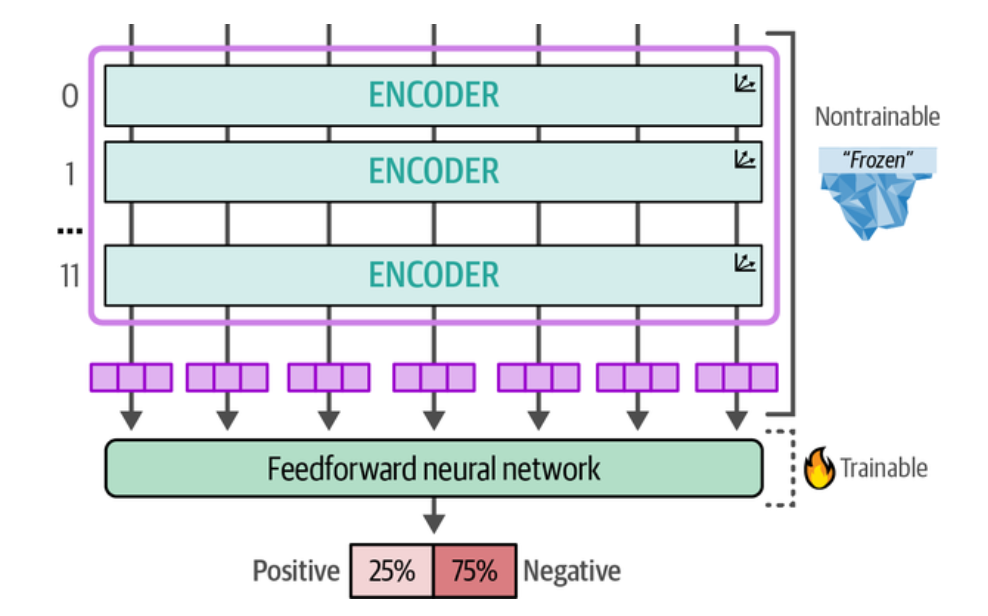

In [ ]:
# 我们可以检查模型是否已正确更新
for name, param in model.named_parameters():
     print(f"Parameter: {name} ----- {param.requires_grad}")

Parameter: bert.embeddings.word_embeddings.weight ----- False
Parameter: bert.embeddings.position_embeddings.weight ----- False
Parameter: bert.embeddings.token_type_embeddings.weight ----- False
Parameter: bert.embeddings.LayerNorm.weight ----- False
Parameter: bert.embeddings.LayerNorm.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: bert.encoder.layer.0.attention.output

In [ ]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

TrainOutput(global_step=534, training_loss=0.6962381677234664, metrics={'train_runtime': 15.234, 'train_samples_per_second': 559.931, 'train_steps_per_second': 35.053, 'total_flos': 227605451772240.0, 'train_loss': 0.6962381677234664, 'epoch': 1.0})

In [ ]:
# 评估结果
trainer.evaluate()

{'eval_loss': 0.6823198795318604,
 'eval_f1': 0.637704918032787,
 'eval_runtime': 2.7203,
 'eval_samples_per_second': 391.865,
 'eval_steps_per_second': 24.629,
 'epoch': 1.0}

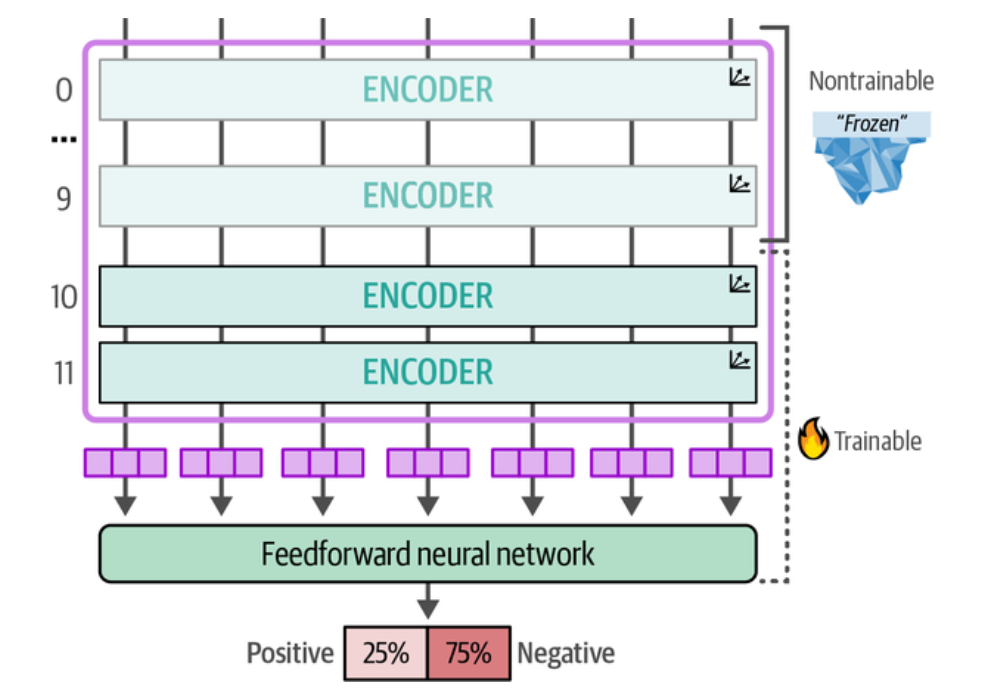

In [ ]:
# 加载模型和分词器
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 编码器区块10从索引165开始，并且我们冻结该区块之前的所有内容
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# 执行训练任务的训练器
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4092540740966797,
 'eval_f1': 0.8141086749285034,
 'eval_runtime': 2.7437,
 'eval_samples_per_second': 388.523,
 'eval_steps_per_second': 24.419,
 'epoch': 1.0}

虽然我们通常希望训练尽可能多的层，但如果没有必要的计算能力，训练较少的层也是可以的。为了进一步说明这种效果，我们测试了迭代冻结编码器块并按我们之前所做的那样进行微调的效果。

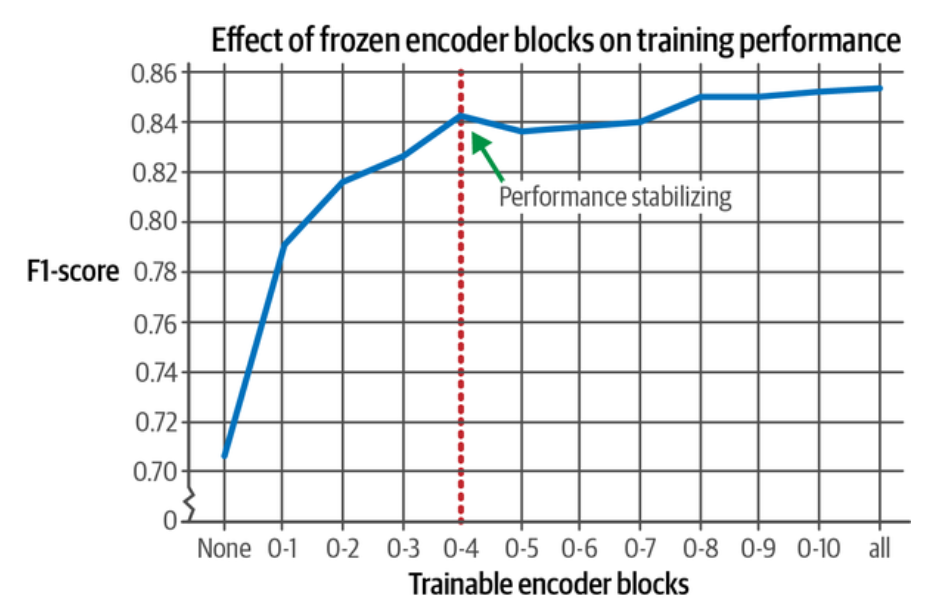

仅训练前五个编码器块（红色垂直线）就足以几乎达到训练所有编码器块的性能。训练更多的块可以提高性能，但性能提升很早就趋于稳定。

- 注意
当您进行多个训练周期时，冻结与不冻结之间的差异（在训练时间和资源方面）通常会变得更大。因此，建议找到一个适合您的平衡点。

## 少样本分类

少样本分类是一种监督分类技术，其中分类器仅基于少量标记示例来学习目标标签。当您有一个分类任务但手头没有许多现成的标记数据点时，这种技术非常有用。换句话说，这种方法允许您为每个类别标记少量高质量的数据点，以训练模型。

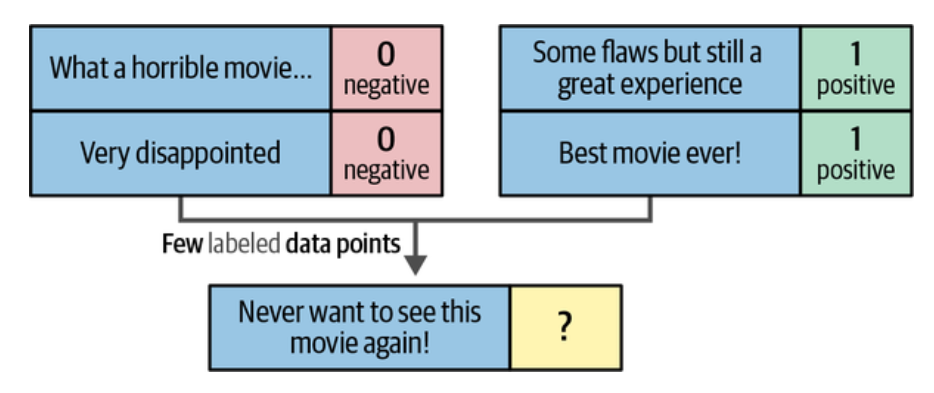

### SetFit：使用少量训练样本的高效微调

该框架建立在sentence-transformers架构之上，用于生成高质量的文本表示，这些表示在训练过程中会进行更新。与之前示例中我们探讨的在大型标记数据集上对类似BERT的模型进行微调相比，该框架仅需少量标记示例即可与之竞争。SetFit的底层算法包含三个步骤：

- 采样训练数据
基于类内和类外标记数据的选择，它生成正（相似）和负（不相似）句子对
- 微调嵌入
基于之前生成的训练数据微调预训练的嵌入模型
- 训练分类器
在嵌入模型之上创建一个分类头，并使用之前生成的训练数据对其进行训练

在微调嵌入模型之前，我们需要生成训练数据。该模型假定训练数据为正（相似）和负（不相似）句子对的样本。然而，当我们处理分类任务时，输入数据通常不会如此标记。

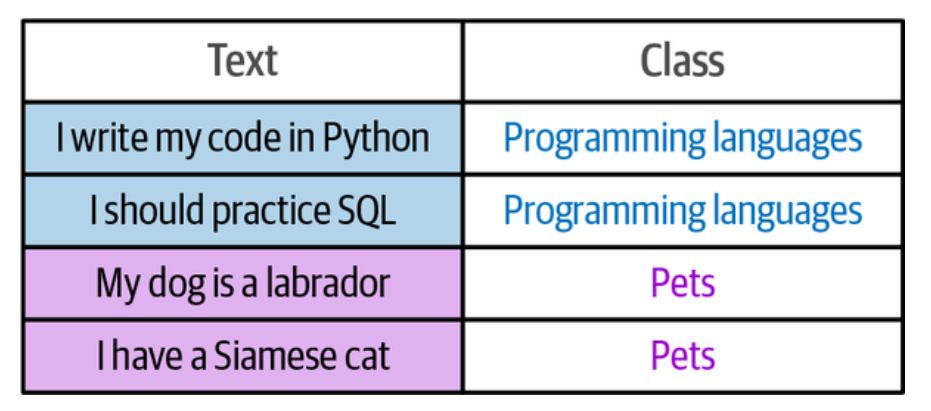

在第一步中，SetFit通过基于类内和类外选择生成必要的数据来解决这个问题。

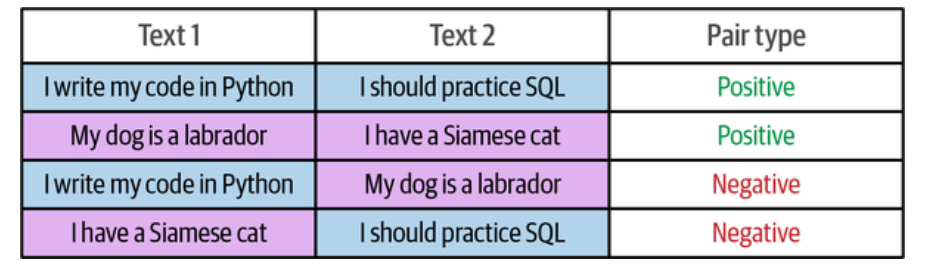

在第二步中，我们可以使用生成的句子对来微调嵌入模型。这利用了一种称为对比学习（对比学习允许从相似（正例）和不相似（负例）句子对中学习准确的句子嵌入）的方法来微调预训练的BERT模型。

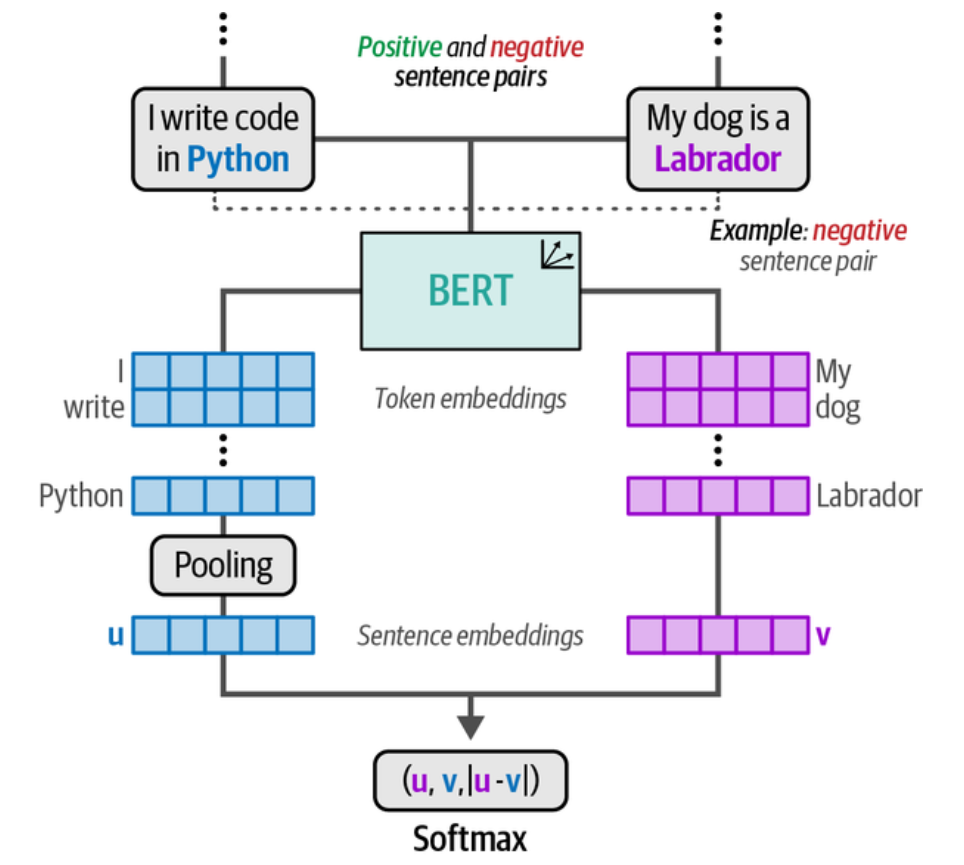

微调这个嵌入模型的目的是使其能够创建针对分类任务进行调整的嵌入。通过微调嵌入模型，类别的相关性和它们的相对意义被提炼到嵌入中。

在第三步中，我们为所有句子生成嵌入，并将它们作为分类器的输入。我们可以使用微调后的SentenceTransformers模型将句子转换为嵌入，这些嵌入可以作为特征使用。分类器从我们的微调嵌入中学习，以准确预测未见过的句子。

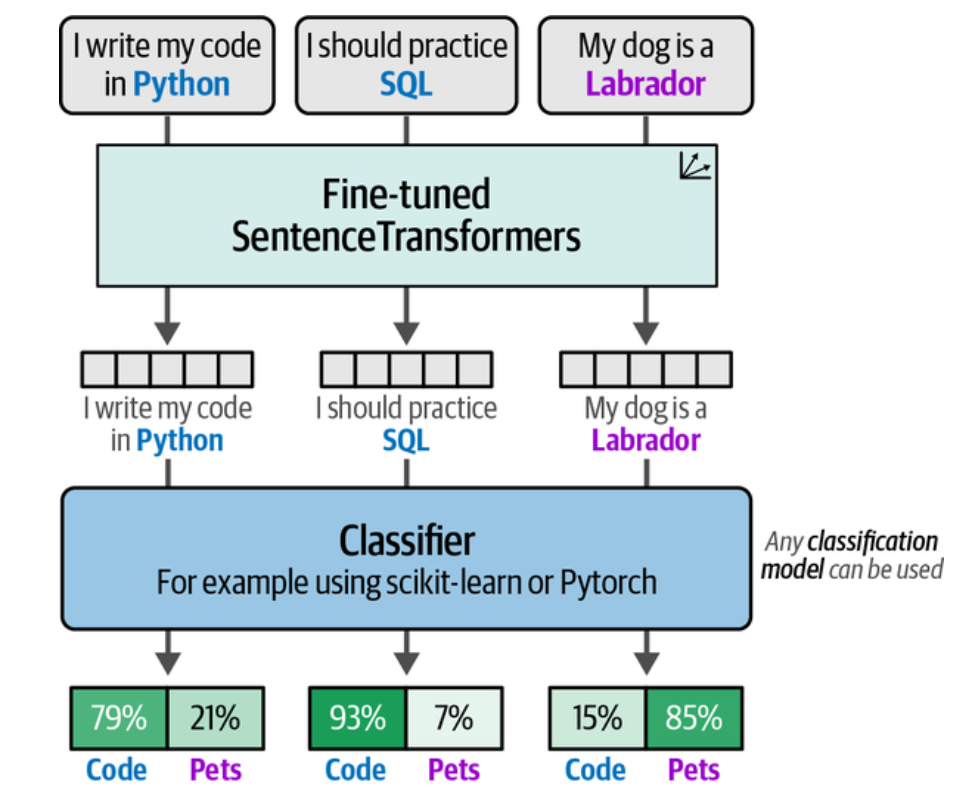

当我们把所有步骤整合在一起时，就得到了一个高效且优雅的流程，用于在每类只有少量标签的情况下进行分类。

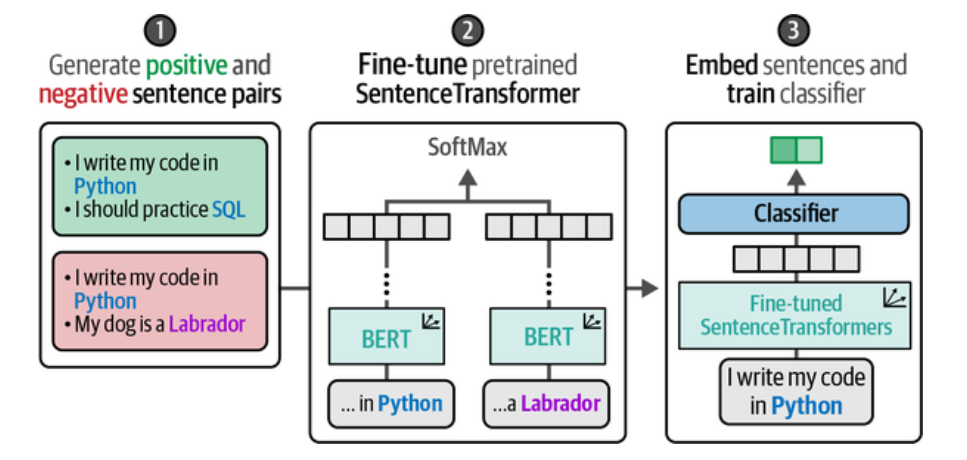

首先，基于类内和类外选择生成句子对。其次，使用这些句子对来微调预训练的SentenceTransformer模型。最后，使用微调后的模型对句子进行嵌入，并在此嵌入模型上训练一个分类器来预测类别。

### 少样本分类的微调

仍使用之前包含大约8,500篇电影评论的数据集，但本次每类将仅采样16个样本。对于两个类别来说，我们仅将有32篇文档用于训练。

In [ ]:
from setfit import sample_dataset

# 我们通过每类采样16个例子来模拟一个少样本设置
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [ ]:
from setfit import SetFitModel

# 加载一个预训练的SentenceTransformer模型
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# 定义SetFitTrainer，默认情况下，选择逻辑回归模型作为要训练的分类器。
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# 定义训练参数
args = SetFitTrainingArguments(
    num_epochs=3, # 用于对比学习的训练轮次（epoch）数
    num_iterations=20  # 要生成的文本对数量
)
args.eval_strategy = args.evaluation_strategy

# 创建训练器
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

我们只需调用train即可开始训练循环：

In [ ]:
# 训练循环
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
  Total optimization steps = 240


输出中提到为微调SentenceTransformer模型生成了1280个句子对。默认情况下，为我们的数据中的每个样本生成20个句子对组合，即20 * 32 = 680个样本。由于为每个正例和负例对都需要生成，因此我们需要将此值乘以2，即680 * 2 = 1280个句子对。

In [ ]:
# 在测试数据上评估模型
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.8363988383349468}

## 继续采用掩码语言模型进行预训练

到目前为止的示例中，我们利用了一个预训练模型，并对其进行了微调以执行分类任务。这个过程描述了一个两步流程：首先是预训练一个模型（这一步已经为我们完成），然后针对特定任务对其进行微调。

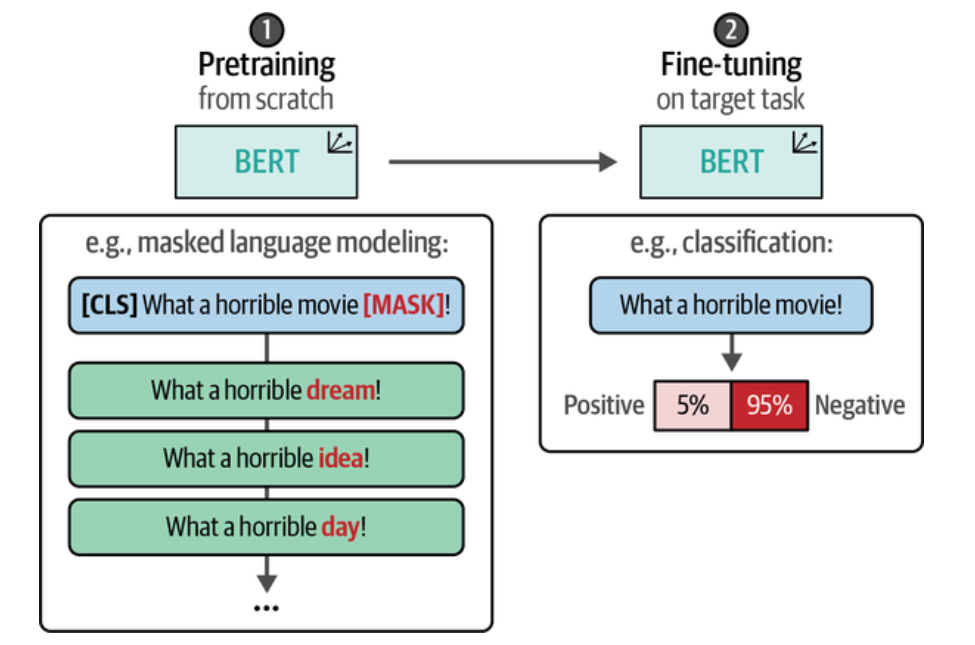

这种两步方法在许多应用中通常被采用。但当面对特定领域的数据时，它存在局限性。预训练模型通常是在非常通用的数据（如维基百科页面）上进行训练的，可能并不适用于特定领域的词汇。

我们不采用这种两步方法，而是在它们之间插入另一个步骤，即继续对已经预训练的BERT模型进行预训练。换句话说，我们可以继续使用掩码语言模型（MLM）来训练BERT模型，但这次使用的是来自我们特定领域的数据。这就像是从一个通用的BERT模型转变为专门用于医学领域的BioBERT模型，然后再对BioBERT模型进行微调以分类药物。

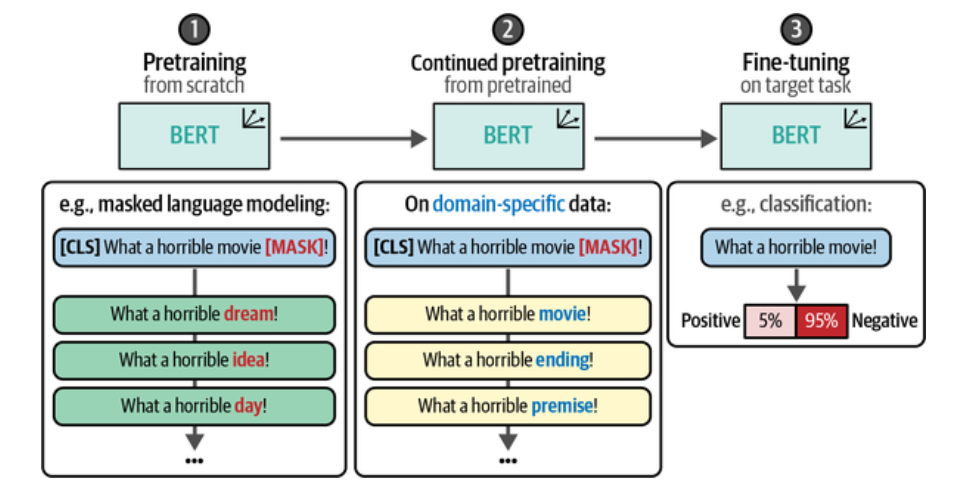

无需从头开始预训练整个模型，只需在对其进行分类微调之前继续预训练即可。这也有助于模型适应某个特定领域，甚至是某个特定组织的行话。

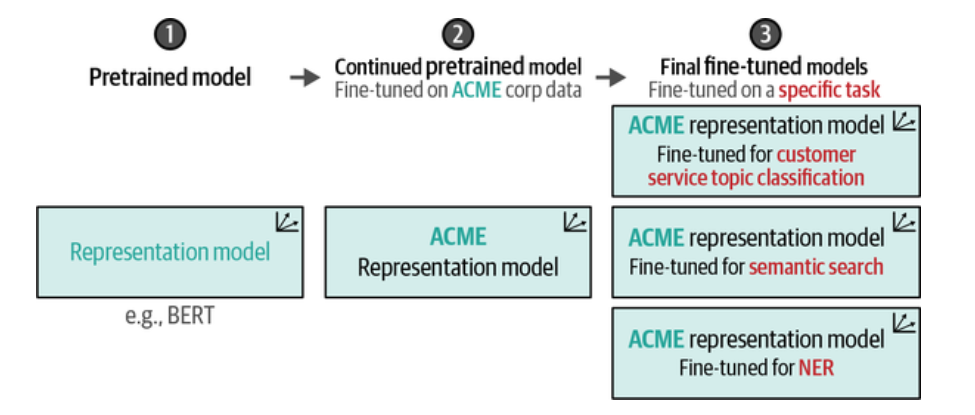

In [ ]:
# 首先加载“bert-base-cased”模型，并为进行掩码语言模型（MLM）做准备：
from transformers import AutoTokenizer, AutoModelForMaskedLM

# 加载用于掩码语言建模（MLM）的模型
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# 将数据分词
# 由于这不是一个监督学习任务，因此我们还会移除标签
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

我们将使用一个DataCollator来为我们执行令牌的掩码操作。
- 令牌掩码
在使用令牌掩码时，我们会随机掩盖句子中15%的令牌。
- 全词掩码
为了能够实现整个单词的掩盖，我们可以使用全词掩码，

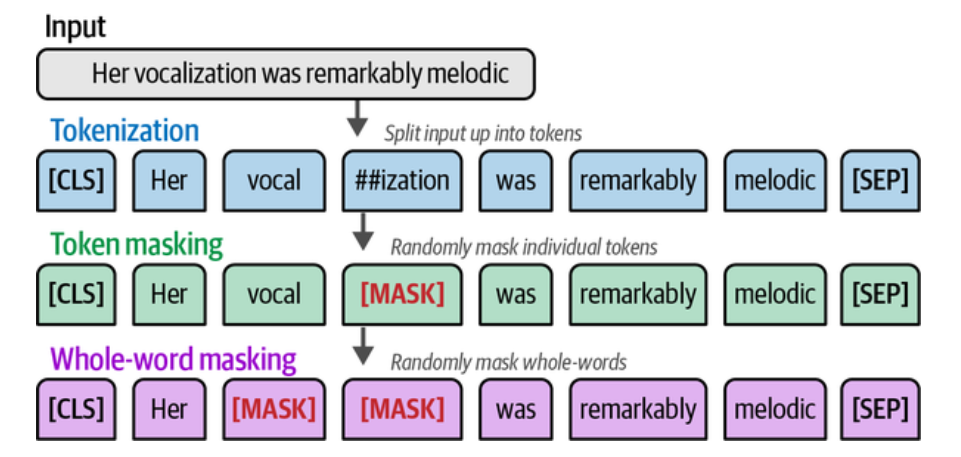

通常，预测整个单词比预测令牌要复杂得多，这会使模型在训练时需要学习更准确和精确的表示，从而使其性能更好。但是，这也往往意味着需要更多的时间来收敛。在本例中，为了更快的收敛速度，我们将使用DataCollatorForLanguageModeling进行令牌掩码。然而，我们也可以通过将DataCollatorForLanguageModeling替换为DataCollatorForWholeWordMask来使用全词掩码。最后，我们将给定句子中令牌被掩码的概率设置为15%：

In [ ]:
from transformers import DataCollatorForLanguageModeling

# 令牌掩码
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
# 参数调优的训练参数
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)


# 初始化训练器
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# 保存预训练的分词器
tokenizer.save_pretrained("mlm")

# 训练模型
trainer.train()

# 保存更新后的模型
model.save_pretrained("mlm")

我们可以通过运行一些掩码任务来检查它是否从继续训练中学习到了知识。为此，我们将在继续预训练之前加载我们的预训练模型。以句子“What a horrible [MASK]!”为例，模型将预测哪个单词会出现在“[MASK]”的位置：

In [ ]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [ ]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!


In [ ]:
# 下一步将是在分类任务上对这个模型进行微调
from transformers import AutoModelForSequenceClassification

# Fine-tune for classification
model = AutoModelForSequenceClassification.from_pretrained("mlm", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("mlm")

## 命名实体识别（NER）

“命名实体识别（Named-Entity Recognition, NER）”是一种自然语言处理技术，用于识别文本中具有特定意义的实体，如人名、地名、组织名等。与对整个文档进行分类不同，该过程可以对单个令牌或单词（包括人名和地点）进行分类。由于我们专注于对单个单词而不是整个文档进行分类，因此我们必须对数据进行预处理，以考虑这种细粒度的结构。

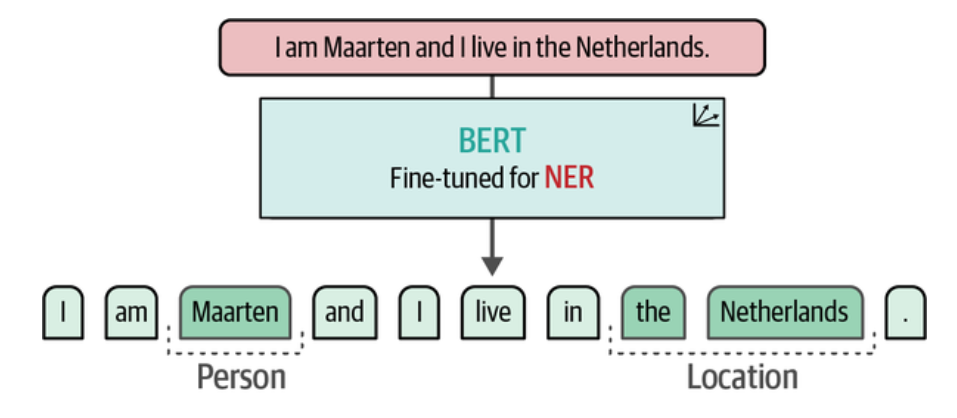

我们的单词级别分类任务并非是对整个单词进行分类，而是对构成这些单词的令牌进行分类。

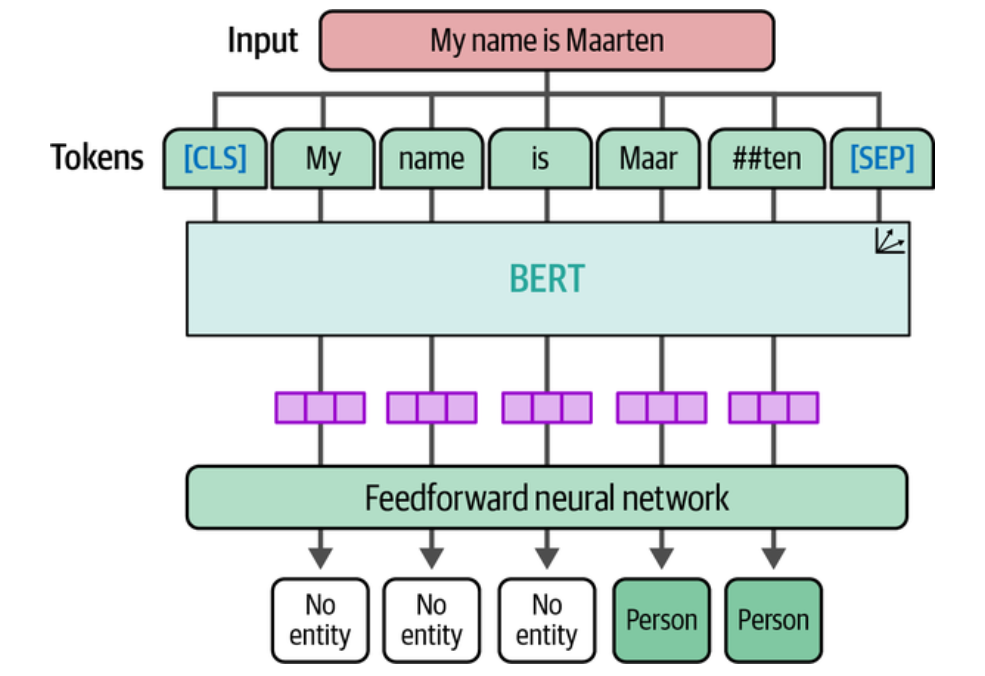

### 为命名实体识别准备数据

我们将使用CoNLL-2003数据集的英文版，该数据集包含几种不同类型的命名实体（人名、组织名、地名、杂项以及无实体），并包含大约14000个训练样本。

In [ ]:
# 用于命名实体识别（NER）的CoNLL-2003数据集
dataset = load_dataset("conll2003", trust_remote_code=True)

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [ ]:
# 这些标签可以在 ner_tags 键中找到，它们对应于以下可能的实体：
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

这些实体对应于特定的类别：人名（PER）、组织名（ORG）、地名（LOC）、杂项实体（MISC）以及无实体（O）。请注意，这些实体前面带有B（开始）或I（内部）前缀。如果两个相邻的令牌属于同一个短语，则该短语的开始部分用B表示，后面跟随I来表示它们属于彼此，而不是独立的实体。

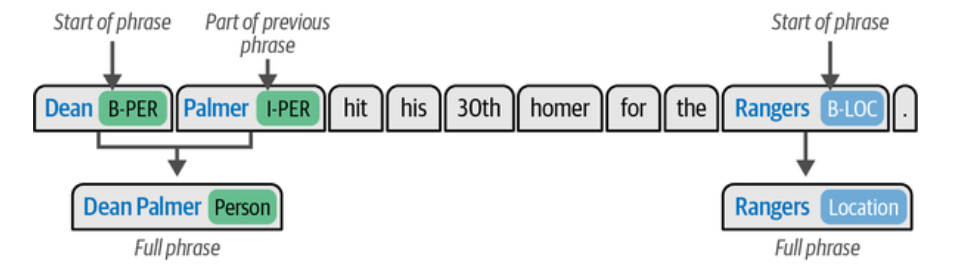

In [ ]:
from transformers import AutoModelForTokenClassification

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 加载模型
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

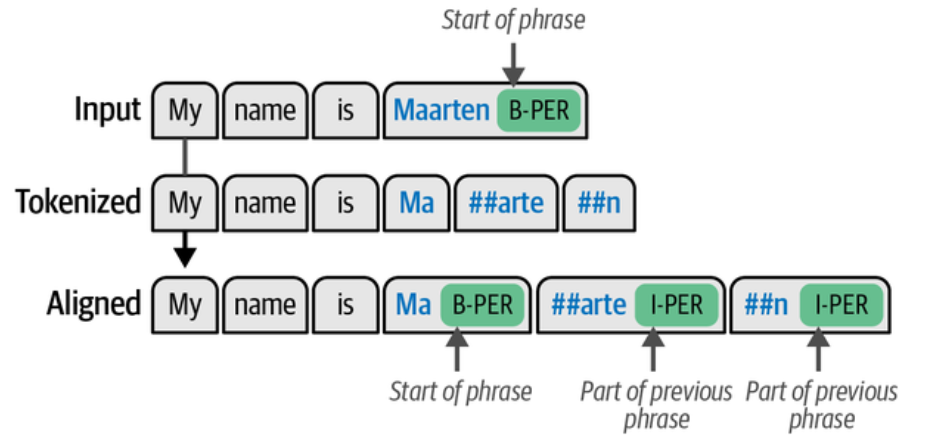

In [ ]:
# 创建了一个名为align_labels的函数，该函数将对输入进行分词，并在分词过程中将这些令牌与其更新后的标签对齐：
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # 将令牌映射到它们各自的单词
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # 一个新单词的开始
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # 特殊令牌为-100
            elif word_idx is None:
                label_ids.append(-100)

            # 如果标签是B-XXX，我们将其更改为I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
# 原始标签和更新后标签之间的差异
print(f"Original: {example['ner_tags']}")
print(f"Updated: {tokenized['train'][848]['labels']}")

Original: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [ ]:
# 使用evaluate包创建compute_metrics函数，该函数在令牌级别上评估性能：
import evaluate

# 顺序评估加载
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # 创建预测
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # 文档级迭代
    for prediction, label in zip(predictions, labels):

      # 令牌级迭代
      for token_prediction, token_label in zip(prediction, label):

        # 我们忽略特殊标记
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

### 命名实体识别的微调

In [ ]:
from transformers import DataCollatorForTokenClassification

# 令牌分类数据整理器
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
# 参数调优的训练参数
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# 初始化训练器
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

TrainOutput(global_step=878, training_loss=0.04094860494001037, metrics={'train_runtime': 169.4752, 'train_samples_per_second': 82.85, 'train_steps_per_second': 5.181, 'total_flos': 351240792638148.0, 'train_loss': 0.04094860494001037, 'epoch': 1.0})

In [ ]:
# 在测试数据上评估模型
trainer.evaluate()

{'eval_loss': 0.16888542473316193,
 'eval_f1': 0.9180087380808113,
 'eval_runtime': 14.5731,
 'eval_samples_per_second': 236.943,
 'eval_steps_per_second': 14.822,
 'epoch': 1.0}

最后，让我们保存模型并在推理管道中使用它。这允许我们检查某些数据，以便我们可以手动查看推理过程中发生了什么，以及我们是否对输出满意：

In [ ]:
from transformers import pipeline

# 保存我们的微调模型
trainer.save_model("ner_model")

# 在微调模型上运行推理
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

[{'entity': 'B-PER',
  'score': 0.99534035,
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.9928328,
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': 0.9954301,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]

## 总结

在本章中，我们探索了在特定分类任务上对预训练表示模型进行微调的几个任务。
- 我们首先展示了如何微调一个预训练的BERT模型，并通过冻结其架构中的某些层来扩展示例。
- 我们尝试了一种称为SetFit的少样本分类技术，该技术涉及使用有限的标记数据对预训练的嵌入模型和分类头进行微调。仅使用少量标记数据点，该模型就产生了与我们前几章探索的模型相似的性能。
- 接下来，我们深入探讨了持续预训练的概念，其中我们使用预训练的BERT模型作为起点，并使用不同的数据继续对其进行训练。其底层过程——掩码语言建模——不仅用于创建表示模型，还可用于继续预训练模型。
- 最后，我们研究了命名实体识别任务，该任务涉及在非结构化文本中识别特定实体，如人和地点。与之前的示例相比，此分类是在单词级别而不是文档级别上进行的。